<a href="https://colab.research.google.com/github/jameslequang232/Machine_Learning_Tool_for_Insomnia_Screening_Using_NHANES_Data/blob/main/Machine_Learning_Tool_for_Insomnia_Diagnosis_Using_NHANES_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving P_ALQ.xpt to P_ALQ.xpt
Saving P_BIOPRO.XPT to P_BIOPRO.XPT
Saving P_BMX.XPT to P_BMX.XPT
Saving P_BPQ.xpt to P_BPQ.xpt
Saving P_DBQ.xpt to P_DBQ.xpt
Saving P_DEMO.xpt to P_DEMO.xpt
Saving P_DIQ.xpt to P_DIQ.xpt
Saving P_DPQ.xpt to P_DPQ.xpt
Saving P_DR1TOT.XPT to P_DR1TOT.XPT
Saving P_GLU.XPT to P_GLU.XPT
Saving P_HSQ.xpt to P_HSQ.xpt
Saving P_MCQ.xpt to P_MCQ.xpt
Saving P_PAQ.xpt to P_PAQ.xpt
Saving P_RXQ_RX.xpt to P_RXQ_RX.xpt
Saving P_SLQ.xpt to P_SLQ.xpt
Saving P_SMQFAM.xpt to P_SMQFAM.xpt
Saving RXQ_DRUG.xpt to RXQ_DRUG.xpt


In [2]:
 !pip install optuna --upgrade shap xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.7/131.7 MB 7.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.3
    Uninstalling xgboost-3.1.3:
      Successfully uninstalled xgboost-3.1.3


**Training Model **

---

# XGB Optuna Model F1 Optimized

Saved 5379 held-out test cases


[I 2026-02-16 16:48:38,713] A new study created in memory with name: no-name-09215ee4-a4ed-45cb-bedd-551d7eec9599
[I 2026-02-16 16:48:43,166] Trial 0 finished with value: 0.8494779116465864 and parameters: {'n_estimators': 255, 'max_depth': 4, 'learning_rate': 0.1627489086535362, 'subsample': 0.9249426530928984, 'colsample_bytree': 0.5365669698677993, 'gamma': 0.7904485529021711, 'min_child_weight': 1}. Best is trial 0 with value: 0.8494779116465864.
[I 2026-02-16 16:48:48,118] Trial 1 finished with value: 0.9008835341365461 and parameters: {'n_estimators': 259, 'max_depth': 6, 'learning_rate': 0.17829953559637804, 'subsample': 0.8787534858984873, 'colsample_bytree': 0.8605939410793134, 'gamma': 0.4806684891816365, 'min_child_weight': 8}. Best is trial 1 with value: 0.9008835341365461.
[I 2026-02-16 16:48:57,737] Trial 2 finished with value: 0.9134939759036144 and parameters: {'n_estimators': 209, 'max_depth': 8, 'learning_rate': 0.16641534982440948, 'subsample': 0.6168401442790294, 'c


Best XGBoost Params: {'n_estimators': 389, 'max_depth': 7, 'learning_rate': 0.2647306831340233, 'subsample': 0.6943918419483376, 'colsample_bytree': 0.7721129647960169, 'gamma': 0.020069093945309077, 'min_child_weight': 2}
Raw pipeline saved for SHAP

Best Threshold (F2): 0.195

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      3166
           1       0.88      0.95      0.92      2213

    accuracy                           0.93      5379
   macro avg       0.93      0.93      0.93      5379
weighted avg       0.93      0.93      0.93      5379

Saved calibrated model and threshold.


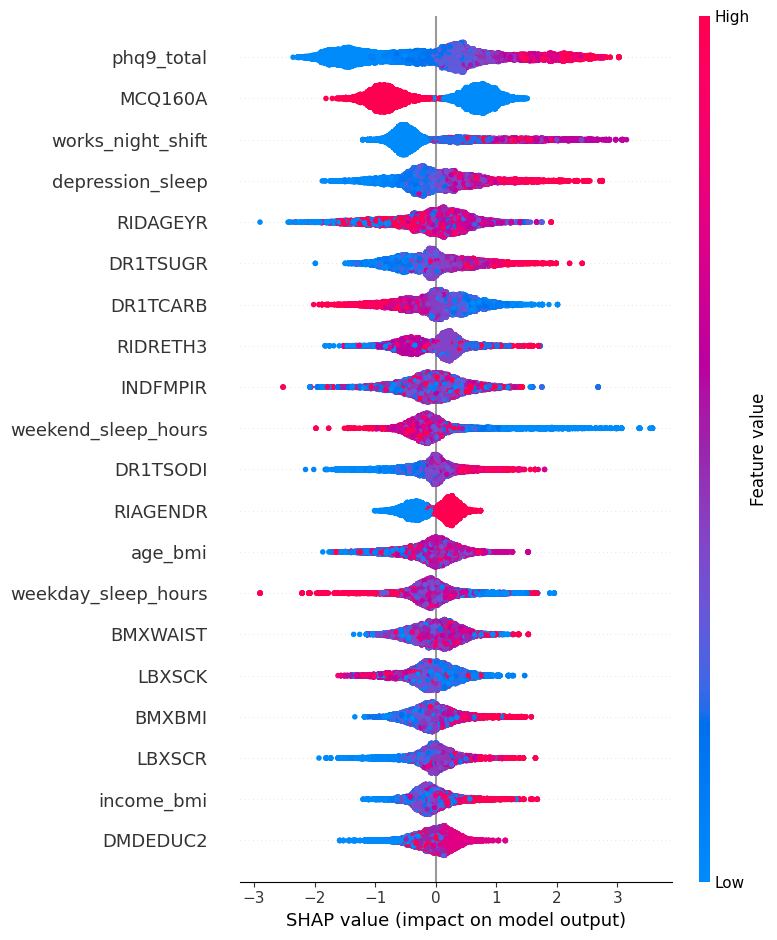

SHAP analysis is done


In [8]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
import optuna
import joblib
import json
import shap

def ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def save_json(path, obj):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

df_demo = pd.read_sas("/content/P_DEMO.xpt")
df_sleep = pd.read_sas("/content/P_SLQ.xpt")
df_dpq = pd.read_sas("/content/P_DPQ.xpt")
df_mcq = pd.read_sas("/content/P_MCQ.xpt")
df_bpq = pd.read_sas("/content/P_BPQ.xpt")
df_rxq = pd.read_sas("/content/P_RXQ_RX.xpt")
df_alq = pd.read_sas("/content/P_ALQ.xpt")
df_bmx = pd.read_sas("/content/P_BMX.XPT")
df_smq = pd.read_sas("/content/P_SMQFAM.xpt")
df_paq = pd.read_sas("/content/P_PAQ.xpt")
df_glu = pd.read_sas("/content/P_GLU.XPT")
df_dbq = pd.read_sas("/content/P_DBQ.xpt")
df_diet = pd.read_sas("/content/P_DR1TOT.XPT")
df_bio = pd.read_sas("/content/P_BIOPRO.XPT")
df_rxq_drug = pd.read_sas("/content/RXQ_DRUG.xpt")
df_hsq = pd.read_sas("/content/P_HSQ.xpt")
df_diq = pd.read_sas("/content/P_DIQ.xpt")

dpq_cols = [f"DPQ0{i}" for i in range(20, 100, 10)]
dpq_cols = [c for c in dpq_cols if c in df_dpq.columns]
df_dpq["phq9_total"] = df_dpq[dpq_cols].sum(axis=1, skipna=True)
dpq_reduced = df_dpq[["SEQN", "phq9_total"] + dpq_cols] if len(dpq_cols) else df_dpq[["SEQN", "phq9_total"]]

df_paq = df_paq[["SEQN", "PAQ605", "PAD615", "PAD630"]].copy()
df_paq = df_paq.rename(columns={"PAQ605": "activity_limited"})

df_sleep = df_sleep.rename(
    columns={
        "SLD012": "weekday_sleep_hours",
        "SLD013": "weekend_sleep_hours",
        "SLQ030": "work_shift",
        "SLQ040": "works_night_shift",
        "SLQ050": "trouble_sleeping",
        "SLQ120": "sleep_disorder",
    }
)

df = df_demo.copy()
merge_tables = [
    df_sleep,
    dpq_reduced,
    df_mcq,
    df_alq,
    df_bmx,
    df_smq,
    df_paq,
    df_dbq,
    df_diet,
    df_bio,
    df_glu,
    df_bpq,
    df_rxq,
    df_rxq_drug,
    df_hsq,
    df_diq
]
for t in merge_tables:
    if "SEQN" in t.columns:
        df = df.merge(t, on="SEQN", how="left")

df = df[df["trouble_sleeping"].notna()].copy()
df["insomnia"] = df["trouble_sleeping"].apply(lambda x: 1 if x == 1 else 0)

def safe_lower(x):
    if isinstance(x, bytes):
        try:
            return x.decode("utf-8").lower()
        except Exception:
            return str(x).lower()
    return str(x).lower()

df_rxq_enriched = df_rxq.merge(
    df_rxq_drug[['RXDDRGID', 'RXDDRUG']].rename(columns={'RXDDRUG': 'DrugNameFromDict'}),
    on='RXDDRGID',
    how='left'
)

df_rxq_enriched['FinalRXDDRUG'] = df_rxq_enriched['DrugNameFromDict'].fillna(df_rxq_enriched['RXDDRUG'])
df_rxq_enriched['FinalRXDDRUG'] = df_rxq_enriched['FinalRXDDRUG'].apply(lambda x: safe_lower(x) if pd.notna(x) else '')

df_rx_combined = df_rxq_enriched.groupby("SEQN")["FinalRXDDRUG"].apply(lambda x: " ".join(x.dropna().unique())).reset_index()
df_rx_combined.rename(columns={"FinalRXDDRUG": "RXDDRUG_string"}, inplace=True)

sleep_meds = [
    "zolpidem",
    "ambien",
    "trazodone",
    "melatonin",
    "temazepam",
    "diphenhydramine",
    "doxylamine",
    "eszopiclone",
    "lunesta",
    "ramelteon",
]
antidepressants = [
    "fluoxetine",
    "sertraline",
    "venlafaxine",
    "citalopram",
    "escitalopram",
]

df_rx_combined["takes_sleep_med"] = df_rx_combined["RXDDRUG_string"].apply(lambda x: int(any(m in x for m in sleep_meds)))
df_rx_combined["takes_antidepressant"] = df_rx_combined["RXDDRUG_string"].apply(lambda x: int(any(m in x for m in antidepressants)))

df = df.merge(df_rx_combined[["SEQN", "takes_sleep_med", "takes_antidepressant"]], on="SEQN", how="left")

df["takes_sleep_med"] = df["takes_sleep_med"].fillna(0).astype(int)
df["takes_antidepressant"] = df["takes_antidepressant"].fillna(0).astype(int)

num_cols = [
    "RIDAGEYR",
    "INDFMPIR",
    "weekday_sleep_hours",
    "weekend_sleep_hours",
    "phq9_total",
    "BMXBMI",
    "BMXWAIST",
    "PAD615",
    "PAD630",
]

num_cols = [c for c in num_cols if c in df.columns]

if "RIDAGEYR" in df.columns and "BMXBMI" in df.columns:
    df["age_bmi"] = df["RIDAGEYR"] * df["BMXBMI"]
    num_cols.append("age_bmi")

if "INDFMPIR" in df.columns and "BMXBMI" in df.columns:
    df["income_bmi"] = df["INDFMPIR"] / (df["BMXBMI"] + 1)
    num_cols.append("income_bmi")

if "phq9_total" in df.columns and "weekday_sleep_hours" in df.columns:
    df["depression_sleep"] = df["phq9_total"] + df["weekday_sleep_hours"]
    num_cols.append("depression_sleep")

if "DR1TCAFF" in df.columns and "RIDAGEYR" in df.columns:
    df["caff_age"] = df["DR1TCAFF"] * df["RIDAGEYR"]
    num_cols.append("caff_age")
else:
    df["caff_age"] = 0
    num_cols.append("caff_age")

extra_cols = [
    "DR1TKCAL",
    "DR1TPROT",
    "DR1TCARB",
    "DR1TTFAT",
    "DR1TSUGR",
    "DR1TSODI",
    "DR1TCHOL",
    "DR1TCAFF",
    "LBXSAL",
    "LBXSAPSI",
    "LBXSASSI",
    "LBXSCK",
    "LBXSCR",
    "LBXSUA",
]

extra_cols = [c for c in extra_cols if c in df.columns]

for col in extra_cols:
    df[f"{col}_missing"] = df[col].isna().astype(int)
    imputed = SimpleImputer(strategy="mean").fit_transform(df[[col]])

    try:
        scaled = StandardScaler().fit_transform(imputed)
    except Exception:
        scaled = imputed
    df[col] = scaled
    num_cols.extend([col, f"{col}_missing"])

cat_cols = [
    "RIAGENDR",
    "RIDRETH3",
    "DMDEDUC2",
    "MCQ160A",
    "ALQ130",
    "activity_limited",
    "work_shift",
    "works_night_shift",
    "DIQ010",
    "HSQ590"
]
cat_cols = [c for c in cat_cols if c in df.columns]

cols_to_clean = [c for c in ["ALQ130", "DMDEDUC2", "work_shift", "DIQ010", "HSQ590"] if c in df.columns]

df[cols_to_clean] = df[cols_to_clean].replace([7, 9, 77, 99, 777, 9999, 7777, 9999], np.nan)

for col in cat_cols:

    df[col] = df[col].astype("category").cat.codes.fillna(-1).astype(int)

label_like = ["trouble_sleeping", "sleep_disorder", "SMD460", "SMD470"]
features = [c for c in (num_cols + cat_cols) if c not in label_like]

X = df[features].copy()
y = df["insomnia"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

held_out = X_test.copy()
held_out["insomnia"] = y_test.values

held_out.to_csv("held_out_test_cases.csv", index=False)

print(f"Saved {len(held_out)} held-out test cases")

save_json("feature_names.json", list(X.columns))
save_json("feature_means.json", X.mean(numeric_only=True).to_dict())

imputer = SimpleImputer(strategy="mean")
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test_imp  = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

smt = SMOTETomek(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train_imp, y_train)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "eval_metric": "aucpr",
        "random_state": 42,
    }
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train_sm, y_train_sm, cv=3, scoring="recall")
    return scores.mean()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
save_json("optuna_best_params.json", best_params)
joblib.dump(study, "optuna_study.pkl")
print("\nBest XGBoost Params:", best_params)

xgb_final = XGBClassifier(**best_params, random_state=42)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('xgb', xgb_final)
])

pipeline.fit(X_train_sm, y_train_sm)

joblib.dump(pipeline, "xgb_pipeline_for_shap.joblib")
print("Raw pipeline saved for SHAP")

xgb_cal = CalibratedClassifierCV(pipeline, method='isotonic', cv=5)
xgb_cal.fit(X_train_sm, y_train_sm)

y_proba = xgb_cal.predict_proba(X_test_imp)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f2 = (5 * precision * recall)/ (4 * precision + recall)
best_thresh = thresholds[f2.argmax()]

y_pred = (y_proba >= best_thresh).astype(int)

print(f"\nBest Threshold (F2): {best_thresh:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

joblib.dump(xgb_cal, "xgb_insomnia_model.joblib")

best_f2_value = f2.max()
save_json("best_threshold_f2.json", {"best_threshold_f2": float(best_thresh), "best_f2": float(best_f2_value)})
print("Saved calibrated model and threshold
")

meta = {
    "features": list(X.columns),
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0]),
    "optuna_best_params": best_params,
    "best_threshold_f2": float(best_thresh),
    "best_f2_on_test": float(best_f2_value),
}
save_json("training_metadata.json", meta)

pipeline = joblib.load("xgb_pipeline_for_shap.joblib")
imputer = pipeline.named_steps['imputer']
scaler = pipeline.named_steps['scaler']
xgb_model = pipeline.named_steps['xgb']

X_train_transformed = imputer.transform(X_train)
X_train_transformed = scaler.transform(X_train_transformed)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=X_train.columns)
joblib.dump(explainer, "shap_explainer.joblib")
joblib.dump(shap_values, "shap_values.joblib")
print("done!")

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary"
)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"AUC:       {auc:.3f}")


Accuracy:  0.930
Precision: 0.884
Recall:    0.955
F1-score:  0.918
AUC:       0.980


In [11]:
import json
with open("features_used.json", "w") as f:
    json.dump(features, f)


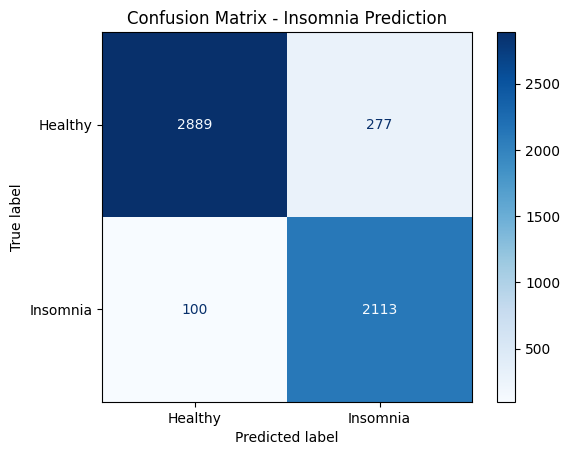

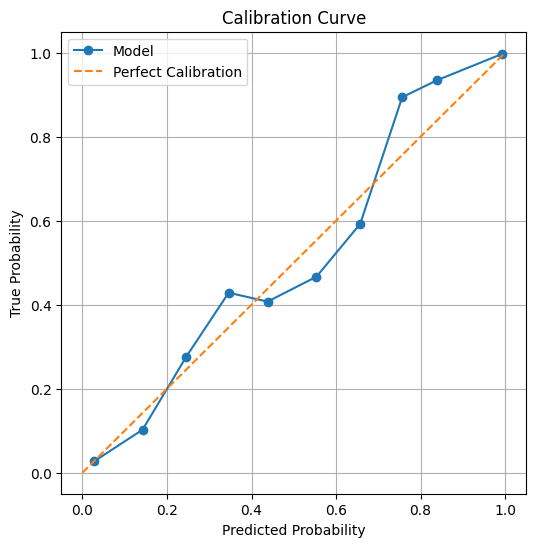

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve # Corrected import

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Insomnia"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Insomnia Prediction")
plt.show()

# --- Calibration Curve ---
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.grid()
plt.show()

In [13]:
!pip install fastapi uvicorn joblib streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.1 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.0
    Uninstalling cachetools-7.0.0:
      Successfully uninstalled cachetools-7.0.0


# Deployment


In [ ]:
 #Desciptions for main.py

 "RIDAGEYR": "Age in years",
    "RIAGENDR": "Gender (1=Male, 2=Female)",
    "INDFMPIR": "Family income-to-poverty ratio",
    "weekday_sleep_hours": "Average weekday sleep hours",
    "weekend_sleep_hours": "Average weekend sleep hours",
    "SLD012": "Trouble falling asleep (0=No, 1=Yes)",
    "SLD013": "Trouble staying asleep (0=No, 1=Yes)",
    "SMD460": "Ever told had trouble sleeping",
    "SMD470": "Ever told had insomnia",
    "PHQ9_total": "Total PHQ-9 depression score",
    "PHQ9_Q1": "PHQ-9: Little interest/pleasure",
    "PHQ9_Q2": "PHQ-9: Feeling down/depressed",
    "PHQ9_Q3": "PHQ-9: Trouble sleeping",
    "PHQ9_Q4": "PHQ-9: Feeling tired",
    "PHQ9_Q5": "PHQ-9: Poor appetite/overeating",
    "PHQ9_Q6": "PHQ-9: Feeling bad about self",
    "PHQ9_Q7": "PHQ-9: Trouble concentrating",
    "PHQ9_Q8": "PHQ-9: Moving/speaking slowly",
    "PHQ9_Q9": "PHQ-9: Thoughts of self-harm",
    "BMXBMI": "Body Mass Index (BMI)",
    "BMXWAIST": "Waist circumference (cm)",
    "BPXSY1": "Systolic blood pressure (mmHg)",
    "BPXDI1": "Diastolic blood pressure (mmHg)",
    "LBXTC": "Total cholesterol (mg/dL)",
    "LBXGLU": "Fasting blood glucose (mg/dL)",
    "LBXGH": "Glycohemoglobin (HbA1c %)",
    "LBXHCT": "Hematocrit (%)",
    "LBXWBCSI": "White blood cell count (1000/uL)",
    "LBXPLTSI": "Platelet count (1000/uL)",
    "MCQ010": "Ever told had asthma (0=No,1=Yes)",
    "MCQ160A": "Ever told had arthritis",
    "MCQ160B": "Ever told had heart failure",
    "MCQ160C": "Ever told had coronary heart disease",
    "MCQ160D": "Ever told had angina",
    "MCQ160E": "Ever told had heart attack",
    "MCQ160F": "Ever told had stroke",
    "MCQ160G": "Ever told had emphysema",
    "MCQ160K": "Ever told had cancer/malignancy",
    "PAD615": "Minutes of moderate physical activity/week",
    "PAD630": "Minutes of vigorous physical activity/week",
    "PAQ605": "Walking/biking for transportation (Yes/No)",
    "SMQ020": "Current smoking status",
    "SMQ040": "Ever smoked at least 100 cigarettes",
    "ALQ101": "Had at least 12 alcohol drinks lifetime",
    "ALQ120Q": "Days drank alcohol in past 12 months",
    "DR1TKCAL": "Daily total calorie intake",
    "DR1TPROT": "Daily protein intake (g)",
    "DR1TCARB": "Daily carbohydrate intake (g)",
    "DR1TSUGR": "Daily total sugar intake (g)",
    "DR1TTFAT": "Daily total fat intake (g)",
    "DR1TSODI": "Daily sodium intake (mg)",
    "RXDUSE": "Currently taking prescription meds",

SyntaxError: illegal target for annotation (ipython-input-957397779.py, line 1)

In [14]:
import pandas as pd
import json

with open ("features_used.json", "r") as f:
  features = json.load(f)

X_train_df = pd.DataFrame(X_train, columns=features)
X_train_df.head(100).to_csv("X_train_sample.csv", index= False)
print("Saved X_train_sample.csv with shape", X_train_df.head(100).shape)

Saved X_train_sample.csv with shape (100, 51)


In [15]:
with open("features_used.json", "r") as f:
  features = json.load(f)

print(features)

['RIDAGEYR', 'INDFMPIR', 'weekday_sleep_hours', 'weekend_sleep_hours', 'phq9_total', 'BMXBMI', 'BMXWAIST', 'PAD615', 'PAD630', 'age_bmi', 'income_bmi', 'depression_sleep', 'caff_age', 'DR1TKCAL', 'DR1TKCAL_missing', 'DR1TPROT', 'DR1TPROT_missing', 'DR1TCARB', 'DR1TCARB_missing', 'DR1TTFAT', 'DR1TTFAT_missing', 'DR1TSUGR', 'DR1TSUGR_missing', 'DR1TSODI', 'DR1TSODI_missing', 'DR1TCHOL', 'DR1TCHOL_missing', 'DR1TCAFF', 'DR1TCAFF_missing', 'LBXSAL', 'LBXSAL_missing', 'LBXSAPSI', 'LBXSAPSI_missing', 'LBXSASSI', 'LBXSASSI_missing', 'LBXSCK', 'LBXSCK_missing', 'LBXSCR', 'LBXSCR_missing', 'LBXSUA', 'LBXSUA_missing', 'RIAGENDR', 'RIDRETH3', 'DMDEDUC2', 'MCQ160A', 'ALQ130', 'activity_limited', 'work_shift', 'works_night_shift', 'DIQ010', 'HSQ590']


In [16]:
feature_names = [
    "RIDAGEYR", "INDFMPIR", "weekday_sleep_hours", "weekend_sleep_hours",
    "phq9_total", "BMXBMI", "BMXWAIST",
    "PAD615", "PAD630",
    "age_bmi", "income_bmi", "depression_sleep", "caff_age",
    "DR1TKCAL", "DR1TKCAL_missing",
    "DR1TPROT", "DR1TPROT_missing",
    "DR1TCARB", "DR1TCARB_missing",
    "DR1TTFAT", "DR1TTFAT_missing",
    "DR1TSUGR", "DR1TSUGR_missing",
    "DR1TSODI", "DR1TSODI_missing",
    "DR1TCHOL", "DR1TCHOL_missing",
    "DR1TCAFF", "DR1TCAFF_missing",
    "LBXSAL", "LBXSAL_missing",
    "LBXSAPSI", "LBXSAPSI_missing",
    "LBXSASSI", "LBXSASSI_missing",
    "LBXSCK", "LBXSCK_missing",
    "LBXSCR", "LBXSCR_missing",
    "LBXSUA", "LBXSUA_missing",
    "RIAGENDR", "RIDRETH3", "DMDEDUC2",
    "MCQ160A", "ALQ130",
    "activity_limited", "work_shift", "works_night_shift",
    "DIQ010", "HSQ590"

]
joblib.dump(feature_names, "feature_names.pkl")

['feature_names.pkl']

In [17]:
import pandas as pd
import joblib

numeric_means = df.select_dtypes(include=["number"]).mean().to_dict()

categorical_modes = {
    col: df[col].mode()[0]
    for col in df.select_dtypes(exclude=["number"]).columns
}

feature_defaults = {**numeric_means, **categorical_modes}
joblib.dump(feature_defaults, "feature_means.pkl")



['feature_means.pkl']

In [18]:
print(feature_defaults)

{'SEQN': 117067.44130442866, 'SDDSRVYR': 66.0, 'RIDSTATR': 1.9272301342356748, 'RIAGENDR': 0.5264566987691964, 'RIDAGEYR': 57.59442977726546, 'RIDAGEMN': nan, 'RIDRETH1': 3.255903023091511, 'RIDRETH3': 2.3098203993604285, 'RIDEXMON': 1.491738851459737, 'DMDBORN4': 1.239876547800543, 'DMDYRUSZ': 6.704909902463217, 'DMDEDUC2': 2.283270739597665, 'DMDMARTZ': 1.674978637458246, 'RIDEXPRG': 2.0594613501224206, 'SIALANG': 1.086751199196817, 'SIAPROXY': 1.9718142267504555, 'SIAINTRP': 1.9709218012122114, 'FIALANG': 1.0737312480051069, 'FIAPROXY': 1.995531439514842, 'FIAINTRP': 1.978096074050431, 'MIALANG': 1.078535148747279, 'MIAPROXY': 1.9849332024414188, 'MIAINTRP': 1.974433394511076, 'AIALANGA': 1.1165084453211689, 'WTINTPRP': 23721.984697155134, 'WTMECPRP': 23785.690454754545, 'SDMVPSU': 1.5310303796526978, 'SDMVSTRA': 159.8247499349273, 'INDFMPIR': 2.4943136489767603, 'weekday_sleep_hours': 7.760161989075155, 'weekend_sleep_hours': 8.27498682923158, 'work_shift': 1.3599449670918082, 'wor

In [19]:
import pickle
with open("feature_means.pkl", "rb") as f:
    feature_means = pickle.load(f)

filtered_means = {k: v for k, v in feature_means.items() if k in feature_names}

print(len(filtered_means))

with open("feature_means.pkl", "wb") as f:
    pickle.dump(filtered_means, f)


51


In [20]:
# clean_feature_means.py
import joblib
import numpy as np

def convert_time_to_minutes(value):
    """Convert 'HH:MM' strings/bytes to minutes; keep numerics as-is."""
    if isinstance(value, (bytes, bytearray)):
        value = value.decode("utf-8")
    if isinstance(value, str) and ":" in value:
        try:
            h, m = map(int, value.split(":"))
            return h * 60 + m
        except:
            return np.nan
    try:
        return float(value)
    except:
        return np.nan
print("🔹 Loading feature_means.pkl ...")
feature_means = joblib.load("feature_means.pkl")

cleaned = {k: convert_time_to_minutes(v) for k, v in feature_means.items()}

print("Cleaned. Example values:")
for k, v in list(cleaned.items())[:10]:
    print(f"{k}: {v}")
joblib.dump(cleaned, "feature_means.pkl")
print("Saved cleaned feature_means.pkl")


🔹 Loading feature_means.pkl ...
Cleaned. Example values:
RIAGENDR: 0.5264566987691964
RIDAGEYR: 57.59442977726546
RIDRETH3: 2.3098203993604285
DMDEDUC2: 2.283270739597665
INDFMPIR: 2.4943136489767603
weekday_sleep_hours: 7.760161989075155
weekend_sleep_hours: 8.27498682923158
work_shift: 1.3599449670918082
works_night_shift: 0.8453872754992006
phq9_total: 3.595182403873774
Saved cleaned feature_means.pkl


In [22]:
# main.py
from fastapi import FastAPI
from pydantic import create_model, Field
import pandas as pd
import numpy as np
import joblib
import json

app = FastAPI(
    title="Insomnia Prediction API - By James Lequang",
    summary="Recall-Optimized Machine Learning Model for Insomnia Diagnosis",
    description="""
Hello, my name is James Lequang, and I am the creator of this diagnostic tool for insomnia. Below you can click on the Post/Predict button to use the tool to see if the model believes you have insomnia. In addition, you can view all of the input that the model will ask you in the Schema of the Post/Predict section and in the Features section. The tool is already pre set to the average value from the NHANES 2017-March 2020 Prepandemic Files used in this model. To receive the most accurate score from this model as possible feel free to change the input values to match your cicrumstance. However, I understand that taking the time to fill out much of this data could be tedious, so I would recommend filling out the input for the following: Depression, PHQ9 Total, Age, Weight, Waist Circumference, Weekday and Weekend Sleep Hours, and Caffeine Intake. This would result in a quick indicator to see if you have insomnia. Of couurse please be wary that this model is not always correct. The model has about a 95% accuracy at diagnosing insomnia, and my purpose was to give people the chance to quick self-diagnose themselves to see whether they should contact a medical proffesional. So please do not take the results too seriously and always follow the doctor's advice! Also the output will list the reasons behind its output at the Top Shap Features section I hope that you find this tool helpful!
""",
)

# 1. Load artifacts

model = joblib.load("xgb_insomnia_model.joblib")
explainer = joblib.load("shap_explainer.joblib")

with open("feature_names.json") as f:
    feature_names = json.load(f)

with open("feature_means.json") as f:
    feature_means = json.load(f)

with open("best_threshold_f2.json") as f:
    thresh_data = json.load(f)
    best_threshold = thresh_data["best_threshold_f2"]


print(f"Loaded model with {len(feature_names)} features")
print(f"F2 threshold = {best_threshold:.4f}")

# --------------------------------------------------
# 2. Feature descriptions (optional, UI only)
# --------------------------------------------------
feature_descriptions = {
 #- Desciptions for Main.py -#

    "RIDAGEYR": "Age in years",
    "RIAGENDR": "Gender (1=Male, 2=Female)",
    "INDFMPIR": "Family income-to-poverty ratio",
    "weekday_sleep_hours": "Average weekday sleep hours",
    "weekend_sleep_hours": "Average weekend sleep hours",
    "SLD012": "Trouble falling asleep (0=No, 1=Yes)",
    "SLD013": "Trouble staying asleep (0=No, 1=Yes)",
    "SMD460": "Ever told had trouble sleeping",
    "SMD470": "Ever told had insomnia",
    "PHQ9_total": "Total PHQ-9 depression score",
    "PHQ9_Q1": "PHQ-9: Little interest/pleasure",
    "PHQ9_Q2": "PHQ-9: Feeling down/depressed",
    "PHQ9_Q3": "PHQ-9: Trouble sleeping",
    "PHQ9_Q4": "PHQ-9: Feeling tired",
    "PHQ9_Q5": "PHQ-9: Poor appetite/overeating",
    "PHQ9_Q6": "PHQ-9: Feeling bad about self",
    "PHQ9_Q7": "PHQ-9: Trouble concentrating",
    "PHQ9_Q8": "PHQ-9: Moving/speaking slowly",
    "PHQ9_Q9": "PHQ-9: Thoughts of self-harm",
    "BMXBMI": "Body Mass Index (BMI)",
    "BMXWAIST": "Waist circumference (cm)",
    "BPXSY1": "Systolic blood pressure (mmHg)",
    "BPXDI1": "Diastolic blood pressure (mmHg)",
    "LBXTC": "Total cholesterol (mg/dL)",
    "LBXGLU": "Fasting blood glucose (mg/dL)",
    "LBXGH": "Glycohemoglobin (HbA1c %)",
    "LBXHCT": "Hematocrit (%)",
    "LBXWBCSI": "White blood cell count (1000/uL)",
    "LBXPLTSI": "Platelet count (1000/uL)",
    "MCQ010": "Ever told had asthma (0=No,1=Yes)",
    "MCQ160A": "Ever told had arthritis",
    "MCQ160B": "Ever told had heart failure",
    "MCQ160C": "Ever told had coronary heart disease",
    "MCQ160D": "Ever told had angina",
    "MCQ160E": "Ever told had heart attack",
    "MCQ160F": "Ever told had stroke",
    "MCQ160G": "Ever told had emphysema",
    "MCQ160K": "Ever told had cancer/malignancy",
    "PAD615": "Minutes of moderate physical activity/week",
    "PAD630": "Minutes of vigorous physical activity/week",
    "PAQ605": "Walking/biking for transportation (Yes/No)",
    "SMQ020": "Current smoking status",
    "SMQ040": "Ever smoked at least 100 cigarettes",
    "ALQ101": "Had at least 12 alcohol drinks lifetime",
    "ALQ120Q": "Days drank alcohol in past 12 months",
    "DR1TKCAL": "Daily total calorie intake",
    "DR1TPROT": "Daily protein intake (g)",
    "DR1TCARB": "Daily carbohydrate intake (g)",
    "DR1TSUGR": "Daily total sugar intake (g)",
    "DR1TTFAT": "Daily total fat intake (g)",
    "DR1TSODI": "Daily sodium intake (mg)",
    "RXDUSE": "Currently taking prescription meds",
}

# --------------------------------------------------
# 3. Dynamic Pydantic input model
# --------------------------------------------------
fields = {}
for name in feature_names:
    default = feature_means.get(name, np.nan)
    desc = feature_descriptions.get(name, name)

    fields[name] = (
        float,
        Field(default=float(default) if default == default else None,
              description=desc)
    )

InsomniaInput = create_model("InsomniaInput", **fields)

# --------------------------------------------------
# 4. Endpoints
# --------------------------------------------------
@app.get("/")
def root():
    return {"status": "Insomnia Prediction API is running"}

@app.get("/features")
def list_features():
    return {
        "features": [
            {
                "name": f,
                "default": feature_means.get(f),
                "description": feature_descriptions.get(f, "")
            }
            for f in feature_names
        ]
    }


import numpy as np

def sanitize_for_json(d):
    clean = {}
    for k, v in d.items():
        if v is None:
            clean[k] = None
        elif isinstance(v, (float, np.floating)):
            if np.isnan(v) or np.isinf(v):
                clean[k] = None
            else:
                clean[k] = float(v)
        else:
            clean[k] = v
    return clean

@app.post("/predict")
def predict(payload: InsomniaInput):


    # ------------------------
    # 1. Build input dataframe
    # ------------------------
    row = {
        f: getattr(payload, f, feature_means.get(f))
        for f in feature_names
    }
    df = pd.DataFrame([row], columns=feature_names)

    # 2. Detect all-mean input
    input_dict = payload.dict()

    all_mean_input = True
    for name in feature_names:
        try:
            if float(input_dict.get(name, feature_means[name])) != float(feature_means[name]):
                all_mean_input = False
                break
        except Exception:
            all_mean_input = False
            break

    guidance_note = (
        "Warning: All values are defaults averages! "
        "This can produce very high insomnia probabilities because the model "
        "is optimized for recall and detects population-level risk."
        if all_mean_input
        else
            "Remember this is just what the machine learning model believes, so please take this into light consideration! "

    )

    # ------------------------
    # 2. Predict probability
    # ------------------------
    proba = float(model.predict_proba(df)[0, 1])
    label = int(proba >= best_threshold)

    def risk_band(proba: float) -> str:
      if proba < 0.30:
        return "low"
      elif proba < 0.60:
        return "moderate"
      else:
        return "high"


    # ------------------------
    # 3. SHAP explanation
    # ------------------------
    base_pipeline = model.estimator
    X_trans = base_pipeline.named_steps["imputer"].transform(df)
    X_trans = base_pipeline.named_steps["scaler"].transform(X_trans)

    shap_vals = explainer.shap_values(X_trans)[0]

    shap_df = pd.DataFrame({
        "feature": feature_names,
        "shap_value": shap_vals,
        "abs_shap": np.abs(shap_vals)
    })

    top_features = (
        shap_df.sort_values("abs_shap", ascending=False)
        .head(5)
        .to_dict(orient="records")
    )

    # ------------------------
    # 4. Return response
    # ------------------------
    risk = risk_band(proba)

    return {
      "insomnia_probability": float(proba),
      "predicted_label": int(proba >= best_threshold),
      "threshold_used": best_threshold,
      "risk_band": risk,
      "top_shap_features": top_features
}


Loaded model with 51 features
F2 threshold = 0.1946


In [73]:
from fastapi import FastAPI
from pydantic import create_model, Field
import pandas as pd
import numpy as np
import joblib
import json

app = FastAPI(
    title="Insomnia Prediction API - By James Lequang",
    summary="Recall-Optimized Machine Learning Model for Insomnia Diagnosis",
    description="""
Hello, my name is James Lequang, and I am the creator of this diagnostic tool for insomnia. Below you can click on the Post/Predict button to use the tool to see if the model believes you have insomnia. In addition, you can view all of the input that the model will ask you in the Schema of the Post/Predict section and in the Features section. The tool is already pre set to the average value from the NHANES 2017-March 2020 Prepandemic Files used in this model. To receive the most accurate score from this model as possible feel free to change the input values to match your cicrumstance. However, I understand that taking the time to fill out much of this data could be tedious, so I would recommend filling out the input for the following: Depression, PHQ9 Total, Age, Weight, Waist Circumference, Weekday and Weekend Sleep Hours, and Caffeine Intake. This would result in a quick indicator to see if you have insomnia. Of couurse please be wary that this model is not always correct. The model has about a 95% accuracy at diagnosing insomnia, and my purpose was to give people the chance to quick self-diagnose themselves to see whether they should contact a medical proffesional. So please do not take the results too seriously and always follow the doctor's advice! Also the output will list the reasons behind its output at the Top Shap Features section I hope that you find this tool helpful!
""",
)

model = joblib.load("xgb_insomnia_model.joblib")
explainer = joblib.load("shap_explainer.joblib")

with open("feature_names.json") as f:
    feature_names = json.load(f)

with open("feature_means.json") as f:
    feature_means = json.load(f)

with open("best_threshold_f2.json") as f:
    thresh_data = json.load(f)
    best_threshold = thresh_data["best_threshold_f2"]

print(f"Loaded model with {len(feature_names)} features")
print(f"F2 threshold = {best_threshold:.4f}")

feature_descriptions = {

    "RIDAGEYR": "Age in years",
    "RIAGENDR": "Gender (1=Male, 2=Female)",
    "INDFMPIR": "Family income-to-poverty ratio",
    "weekday_sleep_hours": "Average weekday sleep hours",
    "weekend_sleep_hours": "Average weekend sleep hours",
    "SLD012": "Trouble falling asleep (0=No, 1=Yes)",
    "SLD013": "Trouble staying asleep (0=No, 1=Yes)",
    "SMD460": "Ever told had trouble sleeping",
    "SMD470": "Ever told had insomnia",
    "PHQ9_total": "Total PHQ-9 depression score",
    "PHQ9_Q1": "PHQ-9: Little interest/pleasure",
    "PHQ9_Q2": "PHQ-9: Feeling down/depressed",
    "PHQ9_Q3": "PHQ-9: Trouble sleeping",
    "PHQ9_Q4": "PHQ-9: Feeling tired",
    "PHQ9_Q5": "PHQ-9: Poor appetite/overeating",
    "PHQ9_Q6": "PHQ-9: Feeling bad about self",
    "PHQ9_Q7": "PHQ-9: Trouble concentrating",
    "PHQ9_Q8": "PHQ-9: Moving/speaking slowly",
    "PHQ9_Q9": "PHQ-9: Thoughts of self-harm",
    "BMXBMI": "Body Mass Index (BMI)",
    "BMXWAIST": "Waist circumference (cm)",
    "BPXSY1": "Systolic blood pressure (mmHg)",
    "BPXDI1": "Diastolic blood pressure (mmHg)",
    "LBXTC": "Total cholesterol (mg/dL)",
    "LBXGLU": "Fasting blood glucose (mg/dL)",
    "LBXGH": "Glycohemoglobin (HbA1c %)",
    "LBXHCT": "Hematocrit (%)",
    "LBXWBCSI": "White blood cell count (1000/uL)",
    "LBXPLTSI": "Platelet count (1000/uL)",
    "MCQ010": "Ever told had asthma (0=No,1=Yes)",
    "MCQ160A": "Ever told had arthritis",
    "MCQ160B": "Ever told had heart failure",
    "MCQ160C": "Ever told had coronary heart disease",
    "MCQ160D": "Ever told had angina",
    "MCQ160E": "Ever told had heart attack",
    "MCQ160F": "Ever told had stroke",
    "MCQ160G": "Ever told had emphysema",
    "MCQ160K": "Ever told had cancer/malignancy",
    "PAD615": "Minutes of moderate physical activity/week",
    "PAD630": "Minutes of vigorous physical activity/week",
    "PAQ605": "Walking/biking for transportation (Yes/No)",
    "SMQ020": "Current smoking status",
    "SMQ040": "Ever smoked at least 100 cigarettes",
    "ALQ101": "Had at least 12 alcohol drinks lifetime",
    "ALQ120Q": "Days drank alcohol in past 12 months",
    "DR1TKCAL": "Daily total calorie intake",
    "DR1TPROT": "Daily protein intake (g)",
    "DR1TCARB": "Daily carbohydrate intake (g)",
    "DR1TSUGR": "Daily total sugar intake (g)",
    "DR1TTFAT": "Daily total fat intake (g)",
    "DR1TSODI": "Daily sodium intake (mg)",
    "RXDUSE": "Currently taking prescription meds"
    }

fields = {}
for name in feature_names:
    default = feature_means.get(name, np.nan)
    desc = feature_descriptions.get(name, name)

    fields[name] = (
        float,
        Field(default=float(default) if default == default else None,
              description=desc)
    )

InsomniaInput = create_model("InsomniaInput", **fields)

@app.get("/")
def root():
    return {"status": "Insomnia Prediction API is running"}

@app.get("/features")
def list_features():
    return {
        "features": [
            {
                "name": f,
                "default": feature_means.get(f),
                "description": feature_descriptions.get(f, "")
            }
            for f in feature_names
        ]
    }

import numpy as np

def sanitize_for_json(d):
    clean = {}
    for k, v in d.items():
        if v is None:
            clean[k] = None
        elif isinstance(v, (float, np.floating)):
            if np.isnan(v) or np.isinf(v):
                clean[k] = None
            else:
                clean[k] = float(v)
        else:
            clean[k] = v
    return clean

@app.post("/predict")
def predict(payload: InsomniaInput):

    row = {
        f: getattr(payload, f, feature_means.get(f))
        for f in feature_names
    }
    df = pd.DataFrame([row], columns=feature_names)
    input_dict = payload.dict()

    all_mean_input = True
    for name in feature_names:
        try:
            if float(input_dict.get(name, feature_means[name])) != float(feature_means[name]):
                all_mean_input = False
                break
        except Exception:
            all_mean_input = False
            break

    guidance_note = (
        "Warning: All values are defaults averages! "
        "This can produce very high insomnia probabilities because the model "
        "is optimized for recall and detects population-level risk."
        if all_mean_input
        else
            "Remember this is just what the machine learning model believes, so please take this into light consideration! "

    )
    proba = float(model.predict_proba(df)[0, 1])
    label = int(proba >= best_threshold)

    def risk_band(proba: float) -> str:
      if proba < 0.30:
        return "low"
      elif proba < 0.60:
        return "moderate"
      else:
        return "high"



    base_pipeline = model.estimator
    X_trans = base_pipeline.named_steps["imputer"].transform(df)
    X_trans = base_pipeline.named_steps["scaler"].transform(X_trans)

    shap_vals = explainer.shap_values(X_trans)[0]

    shap_df = pd.DataFrame({
        "feature": feature_names,
        "shap_value": shap_vals,
        "abs_shap": np.abs(shap_vals)
    })

    top_features = (
        shap_df.sort_values("abs_shap", ascending=False)
        .head(5)
        .to_dict(orient="records")
    )
    risk = risk_band(proba)

    return {
      "insomnia_probability": float(proba),
      "predicted_label": int(proba >= best_threshold),
      "threshold_used": best_threshold,
      "risk_band": risk,
      "top_shap_features": top_features
}


Loaded model with 51 features
F2 threshold = 0.1946


In [74]:
code = '''
from fastapi import FastAPI
from pydantic import create_model, Field
import pandas as pd
import numpy as np
import joblib
import json

app = FastAPI(
    title="Insomnia Prediction API - By James Lequang",
    summary="Recall-Optimized Machine Learning Model for Insomnia Diagnosis",
    description="""
Hello, my name is James Lequang, and I am the creator of this diagnostic tool for insomnia. Below you can click on the Post/Predict button to use the tool to see if the model believes you have insomnia. In addition, you can view all of the input that the model will ask you in the Schema of the Post/Predict section and in the Features section. The tool is already pre set to the average value from the NHANES 2017-March 2020 Prepandemic Files used in this model. To receive the most accurate score from this model as possible feel free to change the input values to match your cicrumstance. However, I understand that taking the time to fill out much of this data could be tedious, so I would recommend filling out the input for the following: Depression, PHQ9 Total, Age, Weight, Waist Circumference, Weekday and Weekend Sleep Hours, and Caffeine Intake. This would result in a quick indicator to see if you have insomnia. Of couurse please be wary that this model is not always correct. The model has about a 95% accuracy at diagnosing insomnia, and my purpose was to give people the chance to quick self-diagnose themselves to see whether they should contact a medical proffesional. So please do not take the results too seriously and always follow the doctor's advice! Also the output will list the reasons behind its output at the Top Shap Features section I hope that you find this tool helpful!
""",
)

model = joblib.load("xgb_insomnia_model.joblib")
explainer = joblib.load("shap_explainer.joblib")

with open("feature_names.json") as f:
    feature_names = json.load(f)

with open("feature_means.json") as f:
    feature_means = json.load(f)

with open("best_threshold_f2.json") as f:
    thresh_data = json.load(f)
    best_threshold = thresh_data["best_threshold_f2"]

print(f"Loaded model with {len(feature_names)} features")
print(f"F2 threshold = {best_threshold:.4f}")

feature_descriptions = {

    "RIDAGEYR": "Age in years",
    "RIAGENDR": "Gender (1=Male, 2=Female)",
    "INDFMPIR": "Family income-to-poverty ratio",
    "weekday_sleep_hours": "Average weekday sleep hours",
    "weekend_sleep_hours": "Average weekend sleep hours",
    "SLD012": "Trouble falling asleep (0=No, 1=Yes)",
    "SLD013": "Trouble staying asleep (0=No, 1=Yes)",
    "SMD460": "Ever told had trouble sleeping",
    "SMD470": "Ever told had insomnia",
    "PHQ9_total": "Total PHQ-9 depression score",
    "PHQ9_Q1": "PHQ-9: Little interest/pleasure",
    "PHQ9_Q2": "PHQ-9: Feeling down/depressed",
    "PHQ9_Q3": "PHQ-9: Trouble sleeping",
    "PHQ9_Q4": "PHQ-9: Feeling tired",
    "PHQ9_Q5": "PHQ-9: Poor appetite/overeating",
    "PHQ9_Q6": "PHQ-9: Feeling bad about self",
    "PHQ9_Q7": "PHQ-9: Trouble concentrating",
    "PHQ9_Q8": "PHQ-9: Moving/speaking slowly",
    "PHQ9_Q9": "PHQ-9: Thoughts of self-harm",
    "BMXBMI": "Body Mass Index (BMI)",
    "BMXWAIST": "Waist circumference (cm)",
    "BPXSY1": "Systolic blood pressure (mmHg)",
    "BPXDI1": "Diastolic blood pressure (mmHg)",
    "LBXTC": "Total cholesterol (mg/dL)",
    "LBXGLU": "Fasting blood glucose (mg/dL)",
    "LBXGH": "Glycohemoglobin (HbA1c %)",
    "LBXHCT": "Hematocrit (%)",
    "LBXWBCSI": "White blood cell count (1000/uL)",
    "LBXPLTSI": "Platelet count (1000/uL)",
    "MCQ010": "Ever told had asthma (0=No,1=Yes)",
    "MCQ160A": "Ever told had arthritis",
    "MCQ160B": "Ever told had heart failure",
    "MCQ160C": "Ever told had coronary heart disease",
    "MCQ160D": "Ever told had angina",
    "MCQ160E": "Ever told had heart attack",
    "MCQ160F": "Ever told had stroke",
    "MCQ160G": "Ever told had emphysema",
    "MCQ160K": "Ever told had cancer/malignancy",
    "PAD615": "Minutes of moderate physical activity/week",
    "PAD630": "Minutes of vigorous physical activity/week",
    "PAQ605": "Walking/biking for transportation (Yes/No)",
    "SMQ020": "Current smoking status",
    "SMQ040": "Ever smoked at least 100 cigarettes",
    "ALQ101": "Had at least 12 alcohol drinks lifetime",
    "ALQ120Q": "Days drank alcohol in past 12 months",
    "DR1TKCAL": "Daily total calorie intake",
    "DR1TPROT": "Daily protein intake (g)",
    "DR1TCARB": "Daily carbohydrate intake (g)",
    "DR1TSUGR": "Daily total sugar intake (g)",
    "DR1TTFAT": "Daily total fat intake (g)",
    "DR1TSODI": "Daily sodium intake (mg)",
    "RXDUSE": "Currently taking prescription meds"
    }

fields = {}
for name in feature_names:
    default = feature_means.get(name, np.nan)
    desc = feature_descriptions.get(name, name)

    fields[name] = (
        float,
        Field(default=float(default) if default == default else None,
              description=desc)
    )

InsomniaInput = create_model("InsomniaInput", **fields)

@app.get("/")
def root():
    return {"status": "Insomnia Prediction API is running"}

@app.get("/features")
def list_features():
    return {
        "features": [
            {
                "name": f,
                "default": feature_means.get(f),
                "description": feature_descriptions.get(f, "")
            }
            for f in feature_names
        ]
    }

import numpy as np

def sanitize_for_json(d):
    clean = {}
    for k, v in d.items():
        if v is None:
            clean[k] = None
        elif isinstance(v, (float, np.floating)):
            if np.isnan(v) or np.isinf(v):
                clean[k] = None
            else:
                clean[k] = float(v)
        else:
            clean[k] = v
    return clean

@app.post("/predict")
def predict(payload: InsomniaInput):

    row = {
        f: getattr(payload, f, feature_means.get(f))
        for f in feature_names
    }
    df = pd.DataFrame([row], columns=feature_names)
    input_dict = payload.dict()

    all_mean_input = True
    for name in feature_names:
        try:
            if float(input_dict.get(name, feature_means[name])) != float(feature_means[name]):
                all_mean_input = False
                break
        except Exception:
            all_mean_input = False
            break

    guidance_note = (
        "Warning: All values are defaults averages! "
        "This can produce very high insomnia probabilities because the model "
        "is optimized for recall and detects population-level risk."
        if all_mean_input
        else
            "Remember this is just what the machine learning model believes, so please take this into light consideration! "

    )
    proba = float(model.predict_proba(df)[0, 1])
    label = int(proba >= best_threshold)

    def risk_band(proba: float) -> str:
      if proba < 0.30:
        return "low"
      elif proba < 0.60:
        return "moderate"
      else:
        return "high"



    base_pipeline = model.estimator
    X_trans = base_pipeline.named_steps["imputer"].transform(df)
    X_trans = base_pipeline.named_steps["scaler"].transform(X_trans)

    shap_vals = explainer.shap_values(X_trans)[0]

    shap_df = pd.DataFrame({
        "feature": feature_names,
        "shap_value": shap_vals,
        "abs_shap": np.abs(shap_vals)
    })

    top_features = (
        shap_df.sort_values("abs_shap", ascending=False)
        .head(5)
        .to_dict(orient="records")
    )
    risk = risk_band(proba)

    return {
      "insomnia_probability": float(proba),
      "predicted_label": int(proba >= best_threshold),
      "threshold_used": best_threshold,
      "risk_band": risk,
      "top_shap_features": top_features
}



    '''

with open ("main.py", "w") as f:
    f.write(code)

In [77]:
from google.colab import files
files. download("best_threshold.json")
files. download("main.py")
files. download("xgb_insomnia_model.joblib")
files. download("feature_names.pkl")
files. download("feature_means.pkl")
files. download("shap_explainer.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>